In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

## 进行数据增强，加载数据（数据读取与预处理）

In [2]:
train_datadir = './big_data/train/'
test_datadir  = './big_data/val/'

# https://pytorch-cn.readthedocs.io/zh/latest/torchvision/torchvision-transform/
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# https://pytorch.org/vision/stable/transforms.html
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    transforms.RandomRotation(degrees=(-10, 10)),  #随机旋转，-10到10度之间随机选
    # transforms.RandomHorizontalFlip(p=0.5),  #随机水平翻转 选择一个概率概率
    # transforms.RandomVerticalFlip(p=0.5),  #随机垂直翻转（效果可能会变差）
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0), # 随机视角
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  #随机选择的高斯模糊模糊图像
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的
])

test_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])

train_data = datasets.ImageFolder(train_datadir,transform=train_transforms)

test_data  = datasets.ImageFolder(test_datadir,transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=1)
test_loader  = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=1)

In [3]:
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([4, 3, 224, 224])
Shape of y:  torch.Size([4]) torch.int64


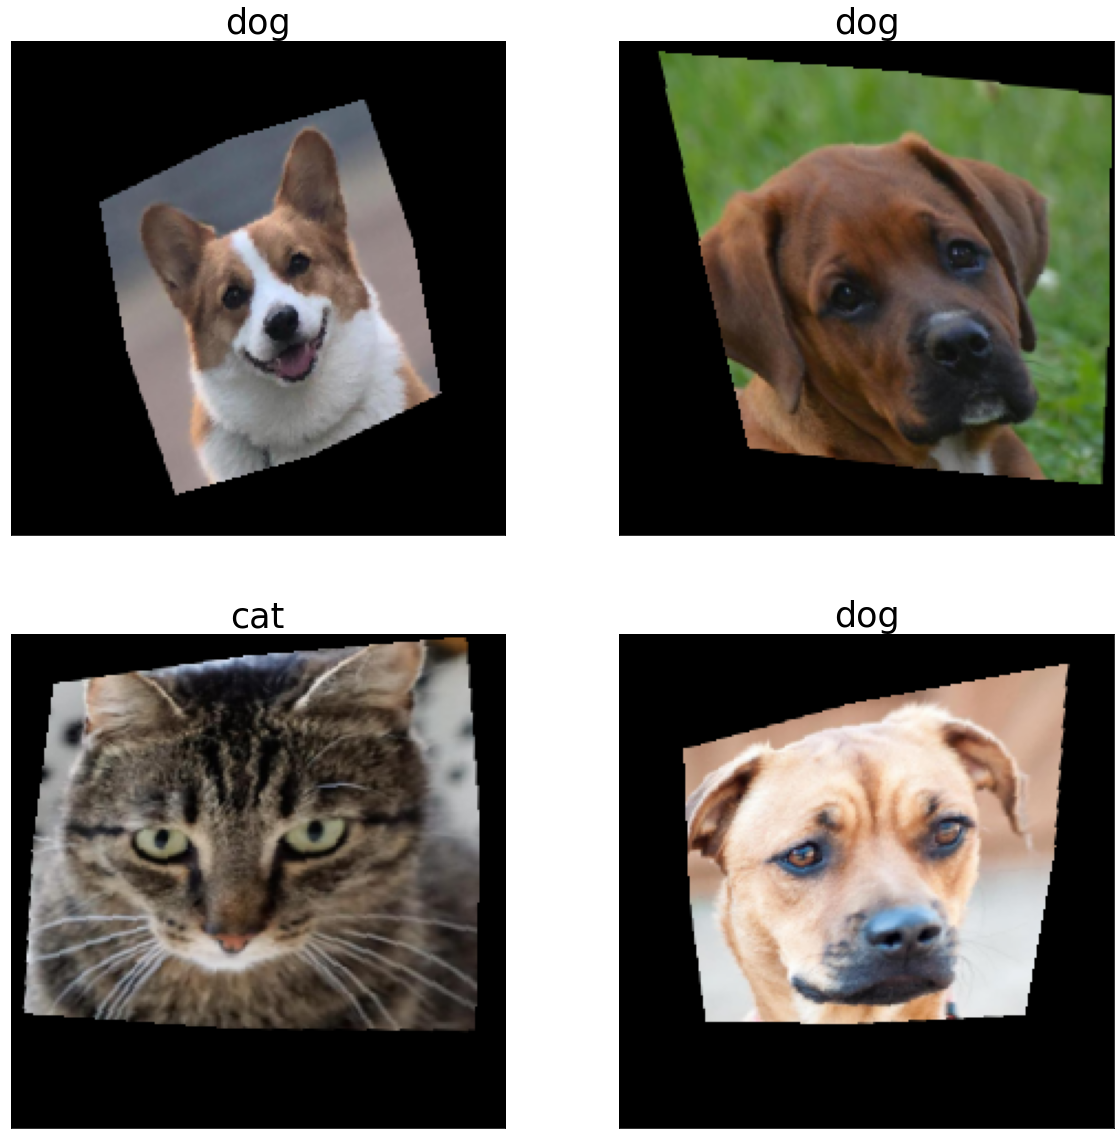

In [26]:
def im_convert(tensor):
    """ 展示数据"""
#     tensor.clone()  返回tensor的拷贝，返回的新tensor和原来的tensor具有同样的大小和数据类型
#     tensor.detach() 从计算图中脱离出来。
    image = tensor.to("cpu").clone().detach()
    
#     numpy.squeeze()这个函数的作用是去掉矩阵里维度为1的维度
    image = image.numpy().squeeze()
    
#     将npimg的数据格式由（channels,imagesize,imagesize）转化为（imagesize,imagesize,channels）,
#     进行格式的转换后方可进行显示
    image = image.transpose(1,2,0)
    
#     和标准差操作正好相反即可
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    
#     使用image.clip(0, 1) 将数据 限制在0和1之间
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 2

dataiter = iter(train_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    if classes[idx] == 0:
        ax.set_title("cat", fontsize = 35)
    else:
        ax.set_title("dog", fontsize = 35)
    plt.imshow(im_convert(inputs[idx]))
plt.savefig('pic1.jpg', dpi=600) #指定分辨率保存
plt.show()

## 定义模型

In [4]:
import torch.nn.functional as F

# 找到可以用于训练的 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 定义模型
class LeNet(nn.Module):
    # 一般在__init__中定义网络需要的操作算子，比如卷积、全连接算子等等
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv2d的第一个参数是输入的channel数量，第二个是输出的channel数量，第三个是kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 由于上一层有16个channel输出，每个feature map大小为53*53，所以全连接层的输入是16*53*53
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        # 最终有10类，所以最后一个全连接层输出数量是10
        self.fc3 = nn.Linear(84, 2)
        self.pool = nn.MaxPool2d(2, 2)
    # forward这个函数定义了前向传播的运算，只需要像写普通的python算数运算那样就可以了
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 下面这步把二维特征图变为一维，这样全连接层才能处理
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device)
print(model)

Using cuda device
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## 损失函数与优化器

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 定义训练函数

在单个训练循环中，模型对训练数据集进行预测（分批提供给它），并反向传播预测误差从而调整模型的参数

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 计算预测误差
        pred = model(X)
        loss = loss_fn(pred, y)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.697169  [    0/ 2819]
loss: 0.717117  [  400/ 2819]
loss: 0.692842  [  800/ 2819]
loss: 0.663078  [ 1200/ 2819]
loss: 0.687370  [ 1600/ 2819]
loss: 0.727401  [ 2000/ 2819]
loss: 0.715081  [ 2400/ 2819]
loss: 0.640342  [ 2800/ 2819]
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.662693 

Epoch 2
-------------------------------
loss: 0.603678  [    0/ 2819]
loss: 0.574420  [  400/ 2819]
loss: 0.609898  [  800/ 2819]
loss: 0.756877  [ 1200/ 2819]
loss: 0.612366  [ 1600/ 2819]
loss: 0.538443  [ 2000/ 2819]
loss: 0.406403  [ 2400/ 2819]
loss: 0.762628  [ 2800/ 2819]
Test Error: 
 Accuracy: 73.8%, Avg loss: 0.603772 

Epoch 3
-------------------------------
loss: 0.532889  [    0/ 2819]
loss: 0.627735  [  400/ 2819]
loss: 0.573161  [  800/ 2819]
loss: 0.369012  [ 1200/ 2819]
loss: 0.450293  [ 1600/ 2819]
loss: 0.562393  [ 2000/ 2819]
loss: 0.436040  [ 2400/ 2819]
loss: 0.464255  [ 2800/ 2819]
Test Error: 
 Accuracy: 63.2%, Avg loss: 0.625167 

Epoc

In [9]:
#保存完整模型
torch.save(model, "model.pth")
#读取
# model = torch.load("model.pth")